<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data,-policy-and-model-initialization" data-toc-modified-id="Data,-policy-and-model-initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data, policy and model initialization</a></span><ul class="toc-item"><li><span><a href="#Load-contact-data" data-toc-modified-id="Load-contact-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load contact data</a></span></li><li><span><a href="#Load-publically-available-data-from-Sciensano" data-toc-modified-id="Load-publically-available-data-from-Sciensano-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load publically available data from Sciensano</a></span></li><li><span><a href="#Load-posterior-parameter-distributions-of-calibrated-parameters" data-toc-modified-id="Load-posterior-parameter-distributions-of-calibrated-parameters-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Load posterior parameter distributions of calibrated parameters</a></span></li><li><span><a href="#Settings" data-toc-modified-id="Settings-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Settings</a></span></li></ul></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Test-vacc-strategy" data-toc-modified-id="Test-vacc-strategy-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test vacc strategy</a></span></li><li><span><a href="#Test-spatial-model" data-toc-modified-id="Test-spatial-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test spatial model</a></span></li><li><span><a href="#Time-dep-functions" data-toc-modified-id="Time-dep-functions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Time-dep functions</a></span></li><li><span><a href="#Scenarios-S1" data-toc-modified-id="Scenarios-S1-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Scenarios S1</a></span><ul class="toc-item"><li><span><a href="#S1a---no-vacc---old-strain" data-toc-modified-id="S1a---no-vacc---old-strain-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>S1a - no vacc - old strain</a></span></li><li><span><a href="#S1b---no-vacc---new-strain" data-toc-modified-id="S1b---no-vacc---new-strain-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>S1b - no vacc - new strain</a></span></li><li><span><a href="#S1c---vaccination---old-strain" data-toc-modified-id="S1c---vaccination---old-strain-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>S1c - vaccination - old strain</a></span></li><li><span><a href="#S1d---vaccination---new-strain" data-toc-modified-id="S1d---vaccination---new-strain-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>S1d - vaccination - new strain</a></span></li><li><span><a href="#Visualise" data-toc-modified-id="Visualise-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>Visualise</a></span></li></ul></li><li><span><a href="#Scenarios-S2" data-toc-modified-id="Scenarios-S2-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Scenarios S2</a></span><ul class="toc-item"><li><span><a href="#S2a---no-vacc---old-strain" data-toc-modified-id="S2a---no-vacc---old-strain-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>S2a - no vacc - old strain</a></span></li><li><span><a href="#S2b---no-vacc---new-strain" data-toc-modified-id="S2b---no-vacc---new-strain-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>S2b - no vacc - new strain</a></span></li><li><span><a href="#S2c---vaccination---old-strain" data-toc-modified-id="S2c---vaccination---old-strain-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>S2c - vaccination - old strain</a></span></li><li><span><a href="#S2d---vaccination---new-strain" data-toc-modified-id="S2d---vaccination---new-strain-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>S2d - vaccination - new strain</a></span></li><li><span><a href="#Visualise" data-toc-modified-id="Visualise-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Visualise</a></span></li></ul></li><li><span><a href="#Save-data" data-toc-modified-id="Save-data-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save data</a></span></li><li><span><a href="#Plot-saved-data" data-toc-modified-id="Plot-saved-data-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plot saved data</a></span></li></ul></div>


*Authored by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime
import scipy
import json
import random
from math import floor

from covid19model.optimization import objective_fcns
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.models.time_dependant_parameter_fncs import ramp_fun, google_lockdown
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator
from covid19model.visualization.optimization import plot_fit, traceplot

plt.rcParams.update({'font.size': 12, 'axes.grid':True, 'grid.linewidth':0.3})
pd.plotting.register_matplotlib_converters()

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Data, policy and model initialization

## Load contact data

In [2]:
# Load the interaction matrices (size: 9x9)
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='all')
# Define the number of age categories
levels = initN.size

initN, Nc_home_15, Nc_work_15, Nc_schools_15, Nc_transport_15, Nc_leisure_15, Nc_others_15, Nc_total_15 = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_15_min')
initN, Nc_home_1hr, Nc_work_1hr, Nc_schools_1hr, Nc_transport_1hr, Nc_leisure_1hr, Nc_others_1hr, Nc_total_1hr = model_parameters.get_interaction_matrices(dataset='willem_2012',intensity='more_one_hour')

In [3]:
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}
Nc_15min = {'total': Nc_total_15, 'home': Nc_home_15, 'work': Nc_work_15, 'schools': Nc_schools_15, 'transport': Nc_transport_15, 'leisure': Nc_leisure_15, 'others': Nc_others_15}
Nc_1hr = {'total': Nc_total_1hr, 'home': Nc_home_1hr, 'work': Nc_work_1hr, 'schools': Nc_schools_1hr, 'transport': Nc_transport_1hr, 'leisure': Nc_leisure_1hr, 'others': Nc_others_1hr}

## Load publically available data from Sciensano

In [4]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano['D_cum'] = df_sciensano.D_tot.cumsum()

In [5]:
df_google = mobility.get_google_mobility_data(update=False, plot=False)

## Load posterior parameter distributions of calibrated parameters

In [6]:
# Load samples dictionaries
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/BE_4_prev_full_2021-01-13_WAVE2_GOOGLE.json', 'r') as fp:
    samples_dict = json.load(fp)

with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/google/initial_states_2020-09-01.json', 'r') as fp:
    initial_states_sept = json.load(fp) 

In [ ]:
# fig,ax = plt.subplots()
# pd.Series(samples_dict['beta']).hist()
# pd.Series(samples_dict['tau']).hist()

## Settings

In [7]:
UL = 0.975
LL = 0.025
infectivity_gain_lower = 1.4
infectivity_gain_upper = 1.7

In [8]:
start_calibration = '2021-01-01'
#end_calibration = '2020-11-12'
end_sim = '2021-09-01'

In [9]:
# for figures
start_x = start_calibration
end_x = '2021-03-15'
end_grid = '2021-02-15'
# n=5
# label_0 = 'no prior vaccination'
# label_10 = 'low prior vaccination'
# label_30 = 'medium prior vaccination'
# label_50 = 'high prior vaccination'

Alle vaccins twee dosissen nodig (Pfizer, Moderna, AstraZeneca, Curevac) behalve Johnson&Johnson (pas vanaf mei)

In [10]:
# doses per day (Regeringscommissariaat Corona, published by De Tijd)
d = {}
d['jan'] = 31765
d['feb'] = 45897
d['mar-apr'] = 128499
d['may-aug'] = 78358

# proportion of age group living in nursing homes
# for simplicity we will use the data for respectively age groups 60+, 70+ and 80+
NH = {}
NH['65+'] = 0.007
NH['75+'] = (0.05+0.029)/2
NH['85+'] = (0.137+0.267)/2


# Functions

In [11]:
def vacc_strategy(t, param, d, NH):
    """
    time-dependent function for vaccination strategy
    
    d : dictionary
        daily number of doses for that month
    NH : dictionary
        proportion of residents in nursing homes per age group
    
    """
    
    N_vacc = np.array([0.0]*9)
    delay = pd.Timedelta('30D')
    
    t1 = pd.Timestamp('2021-01-01') + delay
    t2 = pd.Timestamp('2021-02-01') + delay
    t3 = pd.Timestamp('2021-03-01') + delay
    t4 = pd.Timestamp('2021-05-01') + delay
    
    if t < t1:
        N_vacc = np.array([0.0]*9)
    
    elif t1 <= t < t2: # January : nursing homes + part of care personnel
        # daily vaccinated persons on immunity date = daily dose on vaccination date / 2
        daily_85 = (NH['85+']*initN[8])/31
        daily_75 = (NH['75+']*initN[7])/31
        daily_65 = (NH['65+']*initN[6])/31
        care_personnel_daily_jan = d['jan']/2-daily_85-daily_75-daily_65
        N_vacc[8] = daily_85
        N_vacc[7] = daily_75
        N_vacc[6] = daily_65
        N_vacc[[5,4,3,2]] = care_personnel_daily_jan/4
        
    elif t2 <= t < t3: # February : care personnel
        N_vacc[[5,4,3,2]] = d['feb']/2/4
        
    elif t3 <= t < t4: # March-April : 65+ and risico patients
        plus_65_left_daily = ((1-NH['85+'])*initN[8] + (1-NH['75+'])*initN[7] + (1-NH['65+'])*initN[6])/60
        rest_daily = d['mar-apr']/2 - plus_65_left_daily
        N_vacc[[8,7,6]] = plus_65_left_daily/3
        N_vacc[[5,4,3,2]] = rest_daily/4
    
    else: # May-August : all 18+
        N_vacc[[5,4,3,2]] = d['may-aug']/2/4
        
    return N_vacc
    
    

In [ ]:
def plot_band_saved_data(ax, df, mean_col, LL_col, UL_col, color, label):
    ax.fill_between(df['time'],df[LL_col], df[UL_col],alpha=0.30, facecolor = color)
    ax.plot(df['time'], df[mean_col], color=color, label=label, lw=2)
    return

In [12]:
def plot_band_age(ax, y_model, age_group, var, color, label):
    ax.fill_between(pd.to_datetime(y_model['time'].values),y_model[var].quantile(LL,dim="draws").sel(Nc=age_group), 
                    y_model[var].quantile(UL,dim="draws").sel(Nc=age_group),alpha=0.30, facecolor = color)
    ax.plot(y_model['time'],y_model[var].mean(dim="draws").sel(Nc=age_group), color=color, label=label, lw=2)
    return

In [13]:
def check_overtake_duration(sim, dims):
    """
    sim : data array resulting from simulation
    dims : list of dimensions over which to average
    """
    end = sim['alpha'].mean(dim=dims)[sim['alpha'].mean(dim=dims)<1]['time'][-1].values
    start = sim['alpha'].mean(dim=dims)[sim['alpha'].mean(dim=dims)<1]['time'][0].values
    
    N_days = (pd.to_datetime(end)-pd.to_datetime(start))/pd.Timedelta('1D')
    
    return N_days

In [14]:
def get_date_of_exceeding_alpha(sim, dims, alpha_limit):
    """
    sim : data array resulting from simulation
    dims : list of dimensions over which to average
    """
    return pd.Timestamp(sim['alpha'].mean(dim=dims)[sim['alpha'].mean(dim=dims)>alpha_limit]['time'][0].values)

In [15]:
def sample_from_binomial(sim_result, variable, n_draws_per_sample, n_samples, LL, UL, 
                         Y0_new=None):
                         #Y0_mean=[], Y0_median=[], Y0_LL=[], Y0_UL=[]):
    """
    Function to sample from binomial, and add the result to an existing list (if given)
    """
    
    
    Y = sim_result[variable].sum(dim="Nc").values
    # Initialize vectors
    Y_new = np.zeros((Y.shape[1],n_draws_per_sample*n_samples))
    # Loop over dimension draws
    for n in range(Y.shape[0]):
        binomial_draw = np.random.poisson( np.expand_dims(Y[n,:],axis=1),size = (Y.shape[1],n_draws_per_sample))
        Y_new[:,n*n_draws_per_sample:(n+1)*n_draws_per_sample] = binomial_draw
    # Compute mean and median
    if Y0_new is None:
        Y_new = Y_new
    else:
        Y_new = np.append(Y0_new, Y_new, axis=0)

    return Y_new
    
    

In [16]:
def plot_band_binom(ax, time, Y_binom, color, label, axis=1):
    ax.fill_between(time, np.quantile(Y_binom, q = LL, axis = axis), 
                    np.quantile(Y_binom, q = UL, axis = axis),alpha=0.30, facecolor = color)
    ax.plot(time,np.mean(Y_binom,axis=axis), color=color, label=label, lw=2, linestyle='--')
    return

In [ ]:
# def plot_band(ax, y_model, var, color, label):
#     ax.fill_between(pd.to_datetime(y_model['time'].values),y_model[var].quantile(LL,dim="draws").sum(dim="Nc"), 
#                     y_model[var].quantile(UL,dim="draws").sum(dim="Nc"),alpha=0.30, facecolor = color)
#     ax.plot(y_model['time'],y_model[var].mean(dim="draws").sum(dim="Nc"), color=color, label=label, lw=2)
#     return

# Test vacc strategy

In [ ]:
# Need to initiate I also with the co-infection model, otherwise divison by zero occurs
initial_states = {'S': initN, 'E': np.ones(levels), 'I': np.ones(levels), 'alpha':np.zeros(9)}

In [ ]:
params = model_parameters.get_COVID19_SEIRD_parameters()
dummy_model_no_vacc = models.COVID19_SEIRD(initial_states, params)


In [ ]:
sim_dummy_model_no_vacc = dummy_model_no_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
              })
dummy_model_vacc = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'N_vacc': vacc_strategy})
sim_dummy_model_vacc = dummy_model_vacc.sim(time=end_sim, start_date=start_calibration)

In [ ]:
# Need to initiate I also with the co-infection model, otherwise divison by zero occurs
initial_states = {'S': initN, 'E': np.ones(levels), 'I': np.ones(levels), 'alpha':0.1*np.ones(9)}

params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'d' : d,
               'NH' : NH,
               'e' : np.array([0.9]*levels),
               'K' : 1.6
              })
dummy_model_vacc_UK = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'N_vacc': vacc_strategy})
sim_dummy_model_vacc_UK = dummy_model_vacc_UK.sim(time=end_sim, start_date=start_calibration)

In [ ]:
timerange = pd.date_range(start_calibration,end_sim)
test_dict = {}
for t in timerange:
    test_dict[t] = np.sum(vacc_strategy(t=t, param=None, d=d, NH=NH))
test_df = pd.DataFrame.from_dict(test_dict, orient='index').reset_index()
test_df.columns = ['date','N_vacc']

In [ ]:
fig,ax = plt.subplots(figsize=(9,5))
ax.plot('date', 'N_vacc', data=test_df, c='green', label='time-dep function')
ax.plot(sim_dummy_model_vacc['time'], sim_dummy_model_vacc['V_new'].sum(dim='Nc'), c='blue', linestyle='--', label='model')
ax.legend()
ax.set_ylabel('Daily vaccination number')

In [ ]:
N = d['jan']/2*31+d['feb']/2*28+d['mar-apr']/2*(31+30)+d['may-aug']/2*(31+30)
print('Approximate total number of vaccinations by august 1: {}'.format(N))
#pd.to_datetime(end_sim) - pd.to_datetime(start_calibration)
V_pool_aug = sim_dummy_model_vacc['V'].sum(dim='Nc').values[-1]
print('Number of persons in vaccinated pool by end of simulation: {}'.format(V_pool_aug))
V_new_sum = sim_dummy_model_vacc['V_new'].sum(dim='Nc').sum(dim='time').values
print('Total number of people vaccinated by end of simulation: {}'.format(V_new_sum))

In [ ]:
population_status(sim_dummy_model_no_vacc)

In [ ]:
population_status(sim_dummy_model_vacc)

In [ ]:
population_status(sim_dummy_model_vacc_UK)

In [ ]:
# check evolutie van alpha
fig,ax = plt.subplots()
sim_dummy_model_vacc_UK['alpha'].mean(dim='Nc').plot(ax=ax)

In [ ]:
N_days = check_overtake_duration(sim_dummy_model_vacc_UK, dims='Nc')
N_days

duurt altijd ong. 100 dagen..., onafhankelijk van hoeveel je initialiseert. Ws omdat in deze test het virus nog niet verspreid is (en iedereen susceptible), dus de verspreiding wordt direct volledig overgenomen door besmettelijke variant.

# Test spatial model

In [113]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012', spatial='arr')

In [116]:
# Need to initiate I also with the co-infection model, otherwise divison by zero occurs
initial_states = {'S': initN, 'E': np.ones(initN.shape), 'I': np.ones(initN.shape), 'alpha':np.zeros(initN.shape)}

In [123]:
params = model_parameters.get_COVID19_SEIRD_parameters(spatial='arr')
dummy_spatial_model = models.COVID19_SEIRD_spatial(initial_states, params, spatial='arr')


In [ ]:
sim_dummy_spatial_model = dummy_spatial_model.sim(time=end_sim, start_date=start_calibration)

In [121]:
%debug

> /Users/jennavergeynst/OneDrive - UGent/Corona_Postdoc/COVID19-Model/src/covid19model/models/models.py(400)integrate()
    398                     #term = beta * s[i] * Nc[i,j] * (I_eff[gg,j] + A_eff[gg,j]) / T_eff[gg,j]
    399                     sumj += term
--> 400                 B[gg][i] = sumj
    401 
    402         # Infection from sum over all patches

ipdb> simj
*** NameError: name 'simj' is not defined
ipdb> sumj
array([[7.47007313e-06, 7.47007313e-06, 7.47007313e-06, 7.47007313e-06,
        7.47007313e-06, 7.47007313e-06, 7.47007313e-06, 7.47007313e-06,
        7.47007313e-06],
       [7.47007313e-06, 7.47007313e-06, 7.47007313e-06, 7.47007313e-06,
        7.47007313e-06, 7.47007313e-06, 7.47007313e-06, 7.47007313e-06,
        7.47007313e-06],
       [7.47007313e-06, 7.47007313e-06, 7.47007313e-06, 7.47007313e-06,
        7.47007313e-06, 7.47007313e-06, 7.47007313e-06, 7.47007313e-06,
        7.47007313e-06],
       [7.47007313e-06, 7.47007313e-06, 7.47007313e-06, 7.4700

ipdb> B[gg][i]
0.0
ipdb> q


In [ ]:
B[gg][i]


# Time-dep functions

In [17]:
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function
contact_matrix_4prev = make_contact_matrix_function(df_google, Nc_all)

In [18]:
def report7_policy_function(t, param, l , tau, prev_home, prev_schools, prev_work, prev_rest,scenario='1a'):
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define key policy dates
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-15') # gradual re-opening of schools (assume 50% of nominal scenario)
    t3 = pd.Timestamp('2020-07-01') # start of summer: COVID-urgency very low
    t4 = pd.Timestamp('2020-08-01')
    t5 = pd.Timestamp('2020-09-01') # september: lockdown relaxation narrative in newspapers reduces sense of urgency
    t6 = pd.Timestamp('2020-10-19') # lockdown
    t7 = pd.Timestamp('2020-11-16') # schools re-open
    t8 = pd.Timestamp('2020-12-18') # schools close
    t9 = pd.Timestamp('2020-12-24')
    t10 = pd.Timestamp('2020-12-26')
    t11 = pd.Timestamp('2020-12-31')
    t12 = pd.Timestamp('2021-01-01')
    t13 = pd.Timestamp('2020-01-04') # Opening of schools
    #t14 = pd.Timestamp('2021-01-18') # start of alternative policies
    t15 = pd.Timestamp('2021-02-15') # Start of spring break
    t16 = pd.Timestamp('2021-02-21') # End of spring break
    t17 = pd.Timestamp('2021-03-01') # start of alternative policies (release date)

    # Average out september mobility

    if t5 < t <= t6 + tau_days:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, school=1)
    elif t6 + tau_days < t <= t6 + tau_days + l_days:
        t = pd.Timestamp(t.date())
        policy_old = contact_matrix_4prev(t, school=1)
        policy_new = contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                    school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t6)
    elif t6 + tau_days + l_days < t <= t7:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    elif t7 < t <= t8:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=1)
    elif t8 < t <= t9:
        t = pd.Timestamp(t.date())
        return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
    else:
        # Scenario 1: Current contact behaviour + schools open on January 18th
        if scenario == '1':
            if t9 < t <= t13:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0)
            elif t13 < t <= t15:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            elif t15 < t <= t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0)                                    
            else:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
        # Scenario 2: increases in work or leisure mobility
        elif scenario == '2a':
            if t9 < t <= t13:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
            elif t13 < t <= t15:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            elif t15 < t <= t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0,SB='2a') 
            elif t16 < t <= t17:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6,SB='2a')  
            else:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, 1, 
                                school=0.6,SB='2a')
        elif scenario == '2b':
            if t9 < t <= t13:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
            elif t13 < t <= t15:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            elif t15 < t <= t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0,SB='2b')  
            elif t16 < t <= t17:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6,SB='2b')  
            else:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, prev_work, 1, 
                                school=0.6,SB='2b')
        elif scenario == '2c':
            if t9 < t <= t13:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
            elif t13 < t <= t15:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)
            elif t15 < t <= t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0,SB='2c')                   
            elif t16 < t <= t17:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6,SB='2c')                                                                                
            else:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, 1, 1, prev_rest, 
                                school=0.6,SB='2c')            
        # Scenario 3: Christmas mentality change
        elif scenario == '3':
            if t9 < t <= t10:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, prev_schools, prev_work, 1, 
                              school=0)
            elif t10 < t <= t11:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, prev_schools, prev_work, 1, 
                              school=0)
            elif t11 < t <= t12:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, 1, prev_schools, prev_work, 1, 
                              school=0)
            elif t12 < t <= t13:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                              school=0)
            elif t13 < t <= t15:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)

            elif t15 < t <= t16:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0)                                                                    
            else:
                t = pd.Timestamp(t.date())
                return contact_matrix_4prev(t, prev_home, prev_schools, prev_work, prev_rest, 
                                school=0.6)


In [19]:
def draw_fcn(param_dict,samples_dict,to_sample):
    # Sample
    idx, param_dict['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    param_dict['l'] = samples_dict['l'][idx] 
    param_dict['tau'] = samples_dict['tau'][idx]    
    param_dict['prev_home'] = samples_dict['prev_home'][idx] 
    param_dict['prev_schools'] = samples_dict['prev_schools'][idx]    
    param_dict['prev_work'] = samples_dict['prev_work'][idx]       
    param_dict['prev_rest'] = samples_dict['prev_rest'][idx] 
    param_dict['K'] = np.random.uniform(infectivity_gain_lower,infectivity_gain_upper)
    return param_dict

In [20]:
def vaccin_model(initial_states, scenario, effectivity=None, K=0, Nc_fun=None, N_vacc_fun=vacc_strategy, levels=levels):
    """
    Function to initialize the model given a certain vaccination strategy
    """
    params = model_parameters.get_COVID19_SEIRD_parameters()
    params.update({
            'l' : 5,
            'tau' : 5,
            'prev_home': 0.5,
            'prev_schools': 0.5,
            'prev_work': 0.5,
            'prev_rest': 0.5,
            'scenario': scenario,
            'K' : 0
                  })
    
    tdp = {}
    
    if Nc_fun is not None:
        tdp.update({'Nc': Nc_fun})
    if N_vacc_fun is not None:
        tdp.update({'N_vacc':N_vacc_fun})
        params.update({
            'd' : d,
            'NH' : NH,
            'e' : np.array([effectivity]*levels),
        })
    return models.COVID19_SEIRD(initial_states, params, time_dependent_parameters=tdp)

# Scenarios S1

In [92]:
start_sim1 = '2020-09-01'
end_sim1 = '2021-01-15' # Initiate new strain on 15 Jan
end_sim2 = '2021-05-01'
warmup = 0
n_samples = 5
n_draws_per_sample = 50
effectivity = 0.9
portion_new_strain_introduced = 0.001

In [93]:
scenario = '1'

## S1a - no vacc - old strain

In [23]:
model_S1a = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_S1a = model_S1a.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [24]:
S1a_H_in_binom = sample_from_binomial(out_S1a, 'H_in', n_draws_per_sample, n_samples, LL, UL)
S1a_time = out_S1a["time"].values
S1a_alpha = out_S1a['alpha'].mean(dim="Nc").values

## S1b - no vacc - new strain

In [25]:
model_S1b = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_S1b = model_S1b.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_S1b.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_S1b_part2 = vaccin_model(initial_states_2, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_S1b_part2 = model_S1b_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [26]:
S1b_H_in_binom = sample_from_binomial(out_S1b, 'H_in', n_draws_per_sample, n_samples, LL, UL)
S1b_H_in_binom = sample_from_binomial(out_S1b_part2, 'H_in', n_draws_per_sample, n_samples, LL, UL, S1b_H_in_binom)

In [ ]:
# S1b_H_tot_binom = sample_from_binomial(out_S1b, 'H_tot', n_draws_per_sample, n_samples, LL, UL)
# S1b_H_tot_binom = sample_from_binomial(out_S1b_part2, 'H_tot', n_draws_per_sample, n_samples, LL, UL, S1b_H_tot_binom)

In [27]:
S1b_time = out_S1b["time"].values
S1b_alpha = out_S1b['alpha'].mean(dim="Nc").values
S1b_time = np.append(S1b_time, out_S1b_part2['time'].values)
S1b_alpha = np.append(S1b_alpha,out_S1b_part2['alpha'].mean(dim="Nc").values,axis=1)

## S1c - vaccination - old strain

In [28]:
model_S1c = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S1c = model_S1c.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [29]:
S1c_H_in_binom = sample_from_binomial(out_S1c, 'H_in', n_draws_per_sample, n_samples, LL, UL)
S1c_time = out_S1c["time"].values
S1c_alpha = out_S1c['alpha'].mean(dim="Nc").values

## S1d - vaccination - new strain

In [95]:
model_S1d = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S1d = model_S1d.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_S1d.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_S1d_part2 = vaccin_model(initial_states_2, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S1d_part2 = model_S1d_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [73]:
model_S1d_part2.parameters['beta']

0.03492

In [98]:
S1d_H_in_binom = sample_from_binomial(out_S1d, 'H_in', n_draws_per_sample, n_samples, LL, UL)
S1d_H_in_binom = sample_from_binomial(out_S1d_part2, 'H_in', n_draws_per_sample, n_samples, LL, UL, S1d_H_in_binom)

In [ ]:
# S1d_H_tot_binom = sample_from_binomial(out_S1d, 'H_tot', n_draws_per_sample, n_samples, LL, UL)
# S1d_H_tot_binom = sample_from_binomial(out_S1d_part2, 'H_tot', n_draws_per_sample, n_samples, LL, UL, S1d_H_tot_binom)

In [32]:
S1d_time = out_S1d["time"].values
S1d_alpha = out_S1d['alpha'].mean(dim="Nc").values
S1d_time = np.append(S1d_time, out_S1d_part2['time'].values)
S1d_alpha = np.append(S1d_alpha,out_S1d_part2['alpha'].mean(dim="Nc").values,axis=1)

## Visualise

<IPython.core.display.Javascript object>


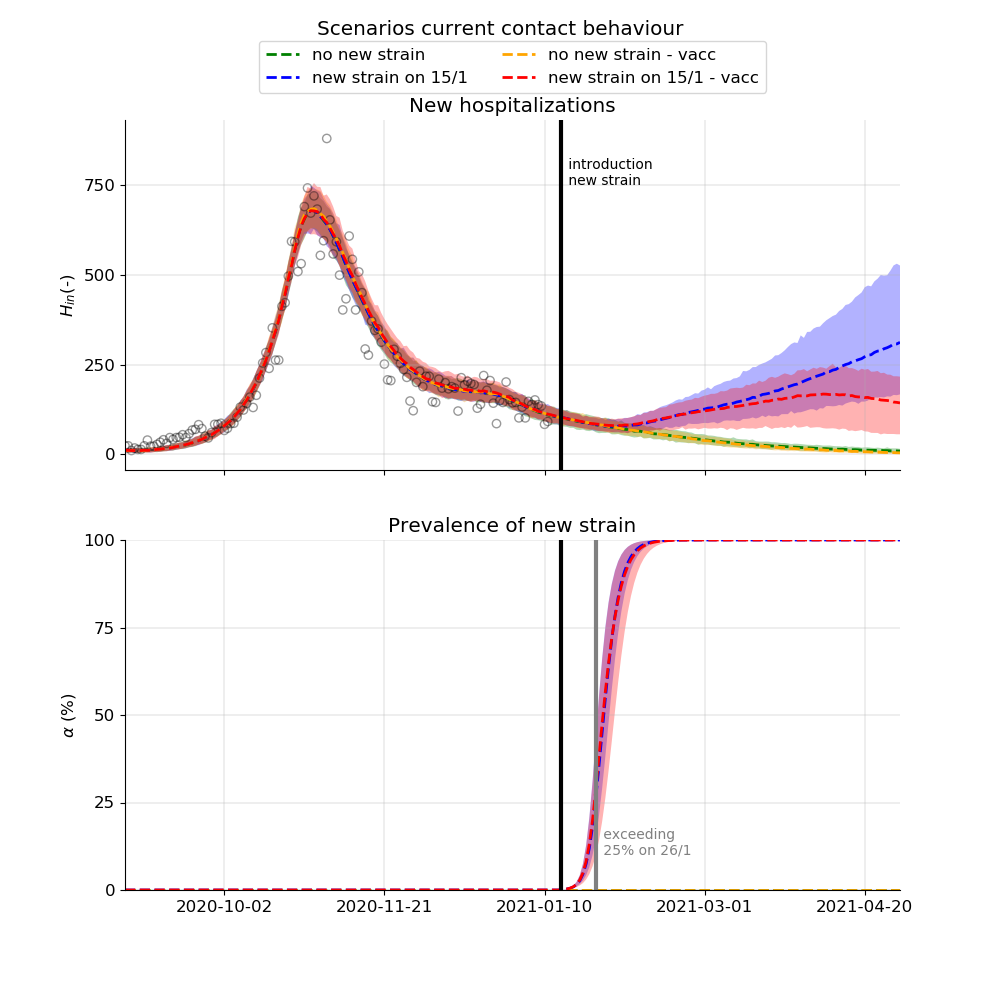

In [36]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1, ax3) = plt.subplots(2,sharex=True,figsize=(10,10))
legend_pos = (0.5, 1.25)
legend_col = 2

# Incidence
plot_band_binom(ax1, S1a_time, S1a_H_in_binom, 'green', label='no new strain')
plot_band_binom(ax1, S1b_time, S1b_H_in_binom, 'blue', label='new strain on 15/1')
plot_band_binom(ax1, S1c_time, S1c_H_in_binom, 'orange', label='no new strain - vacc')
plot_band_binom(ax1, S1d_time, S1d_H_in_binom, 'red', label='new strain on 15/1 - vacc')

ax1.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_in'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax1.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=legend_col)

# Load
# plot_band_binom(ax2, S1b_time, S1b_H_tot_binom, 'blue', label='H_in')
# ax2.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_tot'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')

# British variant
# ax3.plot(S1a_time,np.mean(S1a_alpha,axis=0)*100,'--', color='green', label='no new strain')
# ax3.plot(S1b_time,np.mean(S1b_alpha,axis=0)*100,'--', color='blue', label='new strain on 15/1')
# ax3.fill_between(S1b_time,np.quantile(S1b_alpha,UL,axis=0)*100, np.quantile(S1b_alpha,LL,axis=0)*100,alpha=0.20, color = 'blue')
plot_band_binom(ax3, S1a_time, S1a_alpha*100, 'green', label='no new strain', axis=0)
plot_band_binom(ax3, S1b_time, S1b_alpha*100, 'blue', label='new strain on 15/1', axis=0)
plot_band_binom(ax3, S1c_time, S1c_alpha*100, 'orange', label='no new strain - vacc', axis=0)
plot_band_binom(ax3, S1d_time, S1d_alpha*100, 'red', label='new strain on 15/1 - vacc', axis=0)

# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim2)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax1.text(pd.Timestamp('2021-01-16'),750, ' introduction \n new strain', fontsize=10)
ax1 = _apply_tick_locator(ax1)
# ax2.set_title('Total patients in hospital')
# ax2.set_ylabel('$H_{tot}$ (-)')
# ax2.set_xlim('2020-09-01',end_sim2)
# ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
# ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prevalence of new strain')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax3.set_xlim('2020-09-01',end_sim2)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
date_exceed = get_date_of_exceeding_alpha(out_S1b_part2, ['Nc', 'draws'], 0.25)
ax3.axvline(x=date_exceed, color='gray')
ax3.text(date_exceed+pd.Timedelta('1D'),10, ' exceeding \n 25% on {}/{}'.format(date_exceed.day, date_exceed.month), 
         fontsize=10, color='gray')


fig.suptitle('Scenarios current contact behaviour')

fig_path =  '../../results/predictions/national/restore_v7.0/'
#fig.savefig(fig_path+'restore_v7.0_'+'British_variant'+'.pdf', dpi=400, bbox_inches='tight')
fig.savefig(fig_path+'S1'+'.jpg', dpi=400, bbox_inches='tight')

In [ ]:
date_exceed = get_date_of_exceeding_alpha(out_S1b_part2, ['Nc', 'draws'], 0.25)

In [ ]:
check_overtake_duration(out_S1b_part2, ['Nc', 'draws'])

# Scenarios S2

In [55]:
start_sim1 = '2020-09-01'
end_sim1 = '2021-01-15' # Initiate new strain on 15 Jan
end_sim2 = '2021-07-01'
warmup = 0
n_samples = 5
n_draws_per_sample = 50
effectivity = 0.9
portion_new_strain_introduced = 0.001

In [56]:
scenario = '2a'

## S2a - no vacc - old strain

In [57]:
model_S2a = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_S2a = model_S2a.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [58]:
S2a_H_in_binom = sample_from_binomial(out_S2a, 'H_in', n_draws_per_sample, n_samples, LL, UL)
S2a_time = out_S2a["time"].values
S2a_alpha = out_S2a['alpha'].mean(dim="Nc").values

## S2b - no vacc - new strain

In [59]:
model_S2b = vaccin_model(initial_states_sept, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_S2b = model_S2b.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_S2b.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_S2b_part2 = vaccin_model(initial_states_2, scenario=scenario,Nc_fun=report7_policy_function, N_vacc_fun=None)
out_S2b_part2 = model_S2b_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [60]:
S2b_H_in_binom = sample_from_binomial(out_S2b, 'H_in', n_draws_per_sample, n_samples, LL, UL)
S2b_H_in_binom = sample_from_binomial(out_S2b_part2, 'H_in', n_draws_per_sample, n_samples, LL, UL, S2b_H_in_binom)

In [61]:
# S2b_H_tot_binom = sample_from_binomial(out_S2b, 'H_tot', n_draws_per_sample, n_samples, LL, UL)
# S2b_H_tot_binom = sample_from_binomial(out_S2b_part2, 'H_tot', n_draws_per_sample, n_samples, LL, UL, S2b_H_tot_binom)

In [62]:
S2b_time = out_S2b["time"].values
S2b_alpha = out_S2b['alpha'].mean(dim="Nc").values
S2b_time = np.append(S2b_time, out_S2b_part2['time'].values)
S2b_alpha = np.append(S2b_alpha,out_S2b_part2['alpha'].mean(dim="Nc").values,axis=1)

## S2c - vaccination - old strain

In [63]:
model_S2c = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S2c = model_S2c.sim(end_sim2,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [64]:
S2c_H_in_binom = sample_from_binomial(out_S2c, 'H_in', n_draws_per_sample, n_samples, LL, UL)
S2c_time = out_S2c["time"].values
S2c_alpha = out_S2c['alpha'].mean(dim="Nc").values

## S2d - vaccination - new strain

In [65]:
model_S2d = vaccin_model(initial_states_sept, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S2d = model_S2d.sim(end_sim1,start_date=start_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

# Average and pass on state variables
initial_states_2 = out_S2d.sel(time=end_sim1).mean(dim="draws")
# One promille of British variant on January 15th 2021
initial_states_2['alpha'].values = portion_new_strain_introduced*np.ones(9)
# Re-Initialize
model_S2d_part2 = vaccin_model(initial_states_2, scenario=scenario, effectivity=effectivity, Nc_fun=report7_policy_function, N_vacc_fun=vacc_strategy)
out_S2d_part2 = model_S2d_part2.sim(end_sim2,start_date=end_sim1,warmup=warmup,N=n_samples,draw_fcn=draw_fcn,samples=samples_dict,verbose=True)

In [66]:
S2d_H_in_binom = sample_from_binomial(out_S2d, 'H_in', n_draws_per_sample, n_samples, LL, UL)
S2d_H_in_binom = sample_from_binomial(out_S2d_part2, 'H_in', n_draws_per_sample, n_samples, LL, UL, S2d_H_in_binom)

In [67]:
# S2d_H_tot_binom = sample_from_binomial(out_S2d, 'H_tot', n_draws_per_sample, n_samples, LL, UL)
# S2d_H_tot_binom = sample_from_binomial(out_S2d_part2, 'H_tot', n_draws_per_sample, n_samples, LL, UL, S2d_H_tot_binom)

In [68]:
S2d_time = out_S2d["time"].values
S2d_alpha = out_S2d['alpha'].mean(dim="Nc").values
S2d_time = np.append(S2d_time, out_S2d_part2['time'].values)
S2d_alpha = np.append(S2d_alpha,out_S2d_part2['alpha'].mean(dim="Nc").values,axis=1)

## Visualise

<IPython.core.display.Javascript object>


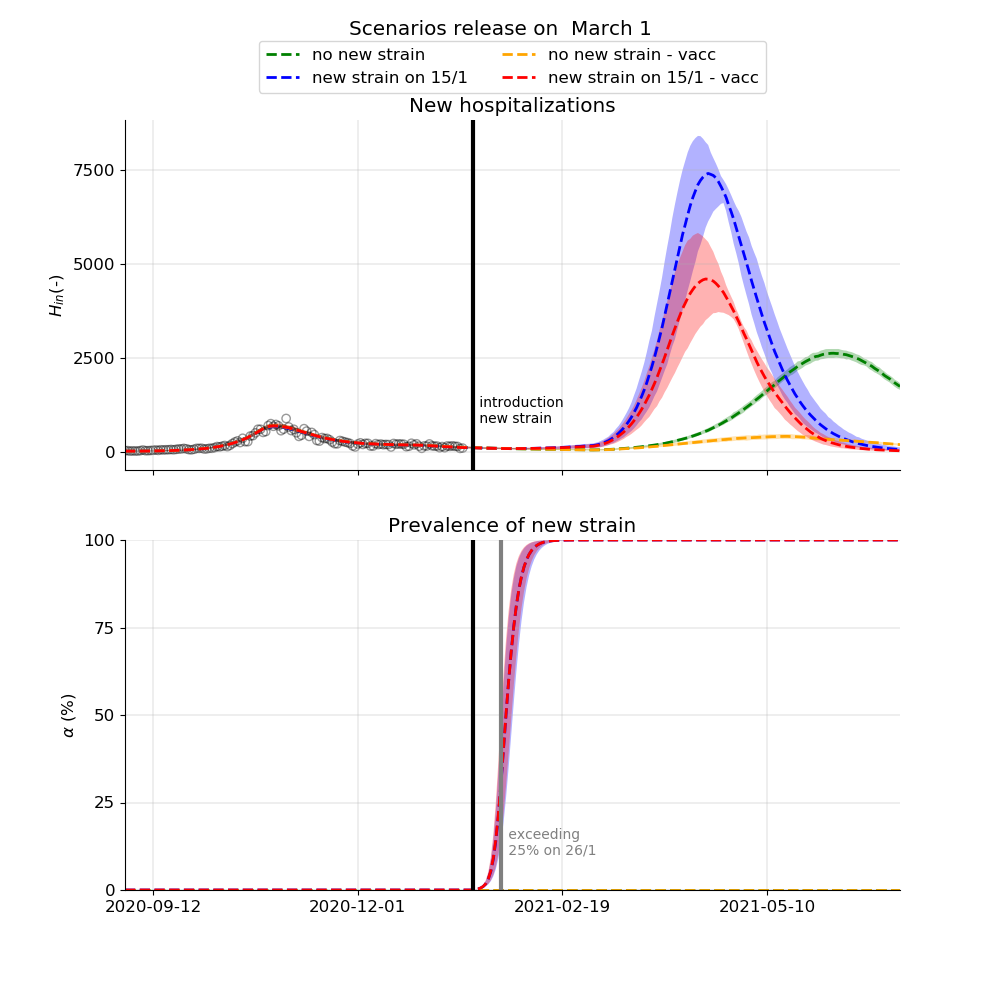

In [69]:
# ----------------
# Visualize result
# ----------------
# Plot
fig,(ax1, ax3) = plt.subplots(2,sharex=True,figsize=(10,10))
legend_pos = (0.5, 1.25)
legend_col = 2

# Incidence
plot_band_binom(ax1, S2a_time, S2a_H_in_binom, 'green', label='no new strain')
plot_band_binom(ax1, S2b_time, S2b_H_in_binom, 'blue', label='new strain on 15/1')
plot_band_binom(ax1, S2c_time, S2c_H_in_binom, 'orange', label='no new strain - vacc')
plot_band_binom(ax1, S2d_time, S2d_H_in_binom, 'red', label='new strain on 15/1 - vacc')

ax1.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_in'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax1.legend(loc='upper center', bbox_to_anchor=legend_pos, ncol=legend_col)

# Load
# plot_band_binom(ax2, S2b_time, S2b_H_tot_binom, 'blue', label='H_in')
# ax2.scatter(df_sciensano[start_sim1:end_sim1].index,df_sciensano['H_tot'][start_sim1:end_sim1],color='black',alpha=0.4,linestyle='None',facecolors='none')

# British variant
# ax3.plot(S2a_time,np.mean(S2a_alpha,axis=0)*100,'--', color='green', label='no new strain')
# ax3.plot(S2b_time,np.mean(S2b_alpha,axis=0)*100,'--', color='blue', label='new strain on 15/1')
# ax3.fill_between(S2b_time,np.quantile(S2b_alpha,UL,axis=0)*100, np.quantile(S2b_alpha,LL,axis=0)*100,alpha=0.20, color = 'blue')
plot_band_binom(ax3, S2a_time, S2a_alpha*100, 'green', label='no new strain', axis=0)
plot_band_binom(ax3, S2b_time, S2b_alpha*100, 'blue', label='new strain on 15/1', axis=0)
plot_band_binom(ax3, S2c_time, S2c_alpha*100, 'orange', label='no new strain - vacc', axis=0)
plot_band_binom(ax3, S2d_time, S2d_alpha*100, 'red', label='new strain on 15/1 - vacc', axis=0)

# Format
ax1.set_title('New hospitalizations')
ax1.set_ylabel('$H_{in} $(-)')
ax1.set_xlim('2020-09-01',end_sim2)
ax1.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax1.text(pd.Timestamp('2021-01-16'),750, ' introduction \n new strain', fontsize=10)
ax1 = _apply_tick_locator(ax1)
# ax2.set_title('Total patients in hospital')
# ax2.set_ylabel('$H_{tot}$ (-)')
# ax2.set_xlim('2020-09-01',end_sim2)
# ax2.axvline(x=pd.to_datetime('2021-01-15'),color='red')
# ax2 = _apply_tick_locator(ax2)
ax3.set_title('Prevalence of new strain')
ax3.set_ylabel('$\\alpha$ (%)')
ax3.axvline(x=pd.to_datetime('2021-01-15'),color='black')
ax3.set_xlim('2020-09-01',end_sim2)
ax3.set_ylim(0,100)
ax3 = _apply_tick_locator(ax3)
date_exceed = get_date_of_exceeding_alpha(out_S2b_part2, ['Nc', 'draws'], 0.25)
ax3.axvline(x=date_exceed, color='gray')
ax3.text(date_exceed+pd.Timedelta('1D'),10, ' exceeding \n 25% on {}/{}'.format(date_exceed.day, date_exceed.month), 
         fontsize=10, color='gray')


fig.suptitle('Scenarios release on  March 1')

fig_path =  '../../results/predictions/national/restore_v7.0/'
#fig.savefig(fig_path+'restore_v7.0_'+'British_variant'+'.pdf', dpi=400, bbox_inches='tight')
fig.savefig(fig_path+'S2'+'.jpg', dpi=400, bbox_inches='tight')

In [ ]:
date_exceed = get_date_of_exceeding_alpha(out_S1b_part2, ['Nc', 'draws'], 0.25)

In [ ]:
check_overtake_duration(out_S1b_part2, ['Nc', 'draws'])

# Save data

In [ ]:
S_results_H_in = pd.DataFrame()
S_results_H_in['time'] =  y_model_S1['time']
var = 'H_in'
for x in ['S1', 'S4a', 'S4b', 'S4c', 'S4d', 'S5a', 'S5b', 'S5c', 'S5d']:
    mod = eval('y_model_'+x)
    S_results_H_in[x] = mod[var].mean(dim="draws").sum(dim="Nc")
    S_results_H_in[x+'_LL'] =  mod[var].quantile(LL,dim="draws").sum(dim="Nc")
    S_results_H_in[x+'_UL'] =  mod[var].quantile(UL,dim="draws").sum(dim="Nc")
S_results_H_in.to_csv('../../results/vaccinations/national/S_results_H_in.csv', index=None)

In [ ]:
S_results_D = pd.DataFrame()
S_results_D['time'] =  y_model_S1['time']
var = 'D'
for x in ['S1', 'S4a', 'S4b', 'S4c', 'S4d', 'S5a', 'S5b', 'S5c', 'S5d']:
    mod = eval('y_model_'+x)
    S_results_D[x] = mod[var].mean(dim="draws").sum(dim="Nc")
    S_results_D[x+'_LL'] =  mod[var].quantile(LL,dim="draws").sum(dim="Nc")
    S_results_D[x+'_UL'] =  mod[var].quantile(UL,dim="draws").sum(dim="Nc")
S_results_D.to_csv('../../results/vaccinations/national/S_results_D.csv', index=None)

In [ ]:
F_results_H_in = pd.DataFrame()
F_results_H_in['time'] =  y_model_F1['time']
var = 'H_in'
for x in ['F1', 'F4a', 'F4b', 'F4c', 'F4d', 'F5a', 'F5b', 'F5c', 'F5d']:
    mod = eval('y_model_'+x)
    F_results_H_in[x] = mod[var].mean(dim="draws").sum(dim="Nc")
    F_results_H_in[x+'_LL'] =  mod[var].quantile(LL,dim="draws").sum(dim="Nc")
    F_results_H_in[x+'_UL'] =  mod[var].quantile(UL,dim="draws").sum(dim="Nc")
F_results_H_in.to_csv('../../results/vaccinations/national/F_results_H_in.csv', index=None)

In [ ]:
F_results_D = pd.DataFrame()
F_results_D['time'] =  y_model_F1['time']
var = 'D'
for x in ['F1', 'F4a', 'F4b', 'F4c', 'F4d', 'F5a', 'F5b', 'F5c', 'F5d']:
    mod = eval('y_model_'+x)
    F_results_D[x] = mod[var].mean(dim="draws").sum(dim="Nc")
    F_results_D[x+'_LL'] =  mod[var].quantile(LL,dim="draws").sum(dim="Nc")
    F_results_D[x+'_UL'] =  mod[var].quantile(UL,dim="draws").sum(dim="Nc")
F_results_D.to_csv('../../results/vaccinations/national/F_results_D.csv', index=None)

# Plot saved data

In [ ]:
S_results_H_in = pd.read_csv('../../results/vaccinations/national/S_results_H_in.csv', parse_dates=['time'])

In [ ]:
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')


In [ ]:
fig,(ax3,ax4) = plt.subplots(figsize=(10,5), nrows=1, ncols=2, sharex=True, sharey=True)

ax3.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')
plot_band_saved_data(ax3, S_results_H_in, 'S1', 'S1_LL', 'S1_UL', 'gray', 'no vaccination')

# plot_band(ax3, y_model_S4a, 'H_in', 'C0', '0% at start')
# plot_band(ax3, y_model_S4b, 'H_in', 'C1', '10% at start')
# plot_band(ax3, y_model_S4c, 'H_in', 'C2', '30% at start')
# plot_band(ax3, y_model_S4d, 'H_in', 'C3', '50% at start')

ax3.set_xlim(start_x, end_x)
ax3.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax3.xaxis.set_tick_params(which='both', labelbottom=True)
ax3.set_title('Vaccination according to age')

ax4.plot('DATE','H_in',data=df_sciensano[start_calibration:end_sim].reset_index(), marker='.', 
         c='gray', label='data', lw=0, markersize=9, alpha=0.3, markeredgecolor='none')
# plot_band(ax4, y_model_S1, 'H_in', 'gray', 'no vaccination')
# plot_band(ax4, y_model_S5a, 'H_in', 'C0', '0% at start')
# plot_band(ax4, y_model_S5b, 'H_in', 'C1', '10% at start')
# plot_band(ax4, y_model_S5c, 'H_in', 'C2', '30% at start')
# plot_band(ax4, y_model_S5d, 'H_in', 'C3', '50% at start')

ax4.set_xlim(start_x, end_x)
ax4.set_xticks(pd.date_range(start_x, end_grid, periods=4))
ax4.xaxis.set_tick_params(which='both', labelbottom=True)
ax4.set_title('Vaccination according to number of contacts')


ax3.legend(loc='upper center', bbox_to_anchor=(1, 1.35), ncol=3)
ax3.set_ylim(0,800)
fig.text(0, 0.5, 'Number of new hospitalizations', va='center', rotation='vertical')
fig.text(0.5, 0.01, 'Time', va='center', rotation='horizontal')
